# Packages and Configurations

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.animation
from matplotlib import pyplot as plt

In [2]:
import hoomd
import gsd.hoomd

cpu = hoomd.device.CPU()
gpu = hoomd.device.GPU()
sim = hoomd.Simulation(device=cpu, seed=np.random.randint(np.iinfo(np.int16).max))

# Plotting

In [3]:
def get_regpoly_patches(sidenum, radius, position, orientation, **kwargs):
    angle = 2 * np.arccos(orientation[:, 0]) * np.sign(orientation[:, 3])
    patches = [mpl.patches.RegularPolygon(position[i, :-1], sidenum, radius, angle[i])
               for i in range(len(position))]
    return mpl.collections.PatchCollection(patches, **kwargs)

def plot_snapshot(ax, snapshot, sidenum, radius, **kwargs):
    box = snapshot.configuration.box
    if "lw" not in kwargs:
        kwargs["lw"] = radius / max(box[0], box[1]) * 25

    ax.add_collection(get_regpoly_patches(
        sidenum, radius, snapshot.particles.position,
        snapshot.particles.orientation, **kwargs))

    ax.set_aspect("equal")
    box_x_extent = box[0] + box[3] * box[1]
    ax.set_xlim((-box_x_extent/2, box_x_extent/2))
    ax.set_ylim((-box[1]/2, box[1]/2))

    return ax

# Square Particle Integrator

In [4]:
radius = 0.5
mc = hoomd.hpmc.integrate.ConvexPolygon()
mc.shape["square"] = dict(vertices=[
    (radius, 0.0),
    (0.0, radius),
    (-radius, 0.0),
    (0.0, -radius),
])
mc.d["square"] = radius / 2
mc.a["square"] = np.pi / 8
sim.operations.integrator = mc

# Initial System Configuration

In [5]:
N_particles = 200
spacing = radius * 2.4
grid_dim = np.math.ceil(N_particles**0.5)
box_size = grid_dim * spacing

In [6]:
coordinates = np.mgrid[
    (-box_size/2 + spacing/2):(box_size/2 - spacing/2):complex(0, grid_dim),
    (-box_size/2 + spacing/2):(box_size/2 - spacing/2):complex(0, grid_dim)
]
lattice = np.column_stack((coordinates[0].flat, coordinates[1].flat))
position = lattice[:N_particles]
position = np.hstack((position, np.zeros((N_particles, 1))))

In [7]:
orientation = np.zeros((N_particles, 4))
orientation[:, -1] = 1

In [8]:
snapshot = gsd.hoomd.Snapshot()
snapshot.particles.N = N_particles
snapshot.particles.position = position
snapshot.particles.orientation = orientation
snapshot.particles.typeid = np.zeros(N_particles, dtype=np.int64)
snapshot.particles.types = ["square"]
snapshot.configuration.box = [box_size, box_size, 0, 0, 0, 0]
with gsd.hoomd.open("lattice.gsd", mode="wb") as f:
    f.append(snapshot)

In [9]:
sim.create_state_from_gsd("lattice.gsd")

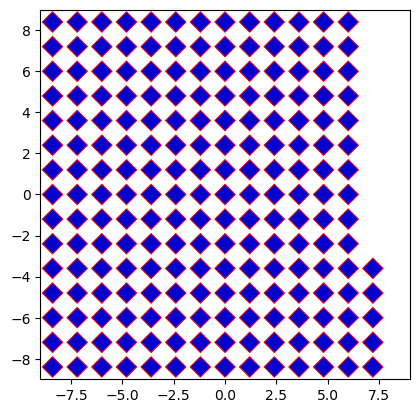

In [10]:
fig, ax = plt.subplots()
plot_snapshot(ax, snapshot, 4, radius, fc="mediumblue", ec="red")
plt.show()

# Mixing the Particles (for Random Initial Conditions)

In [11]:
initial_snapshot = sim.state.get_snapshot()
sim.run(10000)
final_snapshot = sim.state.get_snapshot()

In [12]:
translation_acceptance = mc.translate_moves[0] / sum(mc.translate_moves)
rotation_acceptance = mc.rotate_moves[0] / sum(mc.rotate_moves)
translation_acceptance, rotation_acceptance

(0.7059244884121425, 0.8993929449220758)

In [13]:
initial_snapshot.particles.position[0:4]

array([[-8.39999962, -8.39999962,  0.        ],
       [-8.39999962, -7.19999981,  0.        ],
       [-8.39999962, -6.        ,  0.        ],
       [-8.39999962, -4.80000019,  0.        ]])

In [14]:
final_snapshot.particles.position[0:4]

array([[ 0.16135401,  5.70205298,  0.        ],
       [ 6.69873305, -2.75487595,  0.        ],
       [-8.47267427, -1.82344521,  0.        ],
       [-4.43057489, -2.04090277,  0.        ]])

In [15]:
initial_snapshot.particles.orientation[0:4]

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [16]:
final_snapshot.particles.orientation[0:4]

array([[ 0.99933385,  0.        ,  0.        , -0.03649459],
       [-0.98176794,  0.        ,  0.        ,  0.19008341],
       [-0.20544004,  0.        ,  0.        ,  0.9786697 ],
       [-0.99347766,  0.        ,  0.        , -0.11402695]])

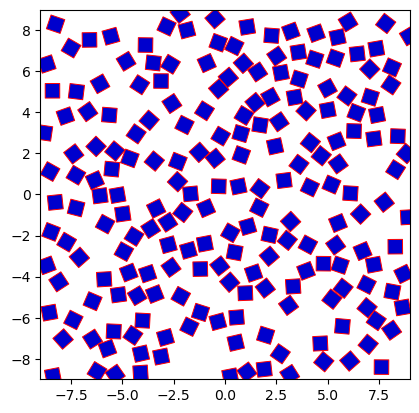

In [17]:
fig, ax = plt.subplots()
plot_snapshot(ax, final_snapshot, 4, 0.5, fc="mediumblue", ec="red")
plt.show()

In [18]:
hoomd.write.GSD.write(sim.state, "mixed.gsd", mode="wb")

# reset the simulator
mc = hoomd.hpmc.integrate.ConvexPolygon()
mc.shape["square"] = dict(vertices=[
    (radius, 0.0),
    (0.0, radius),
    (-radius, 0.0),
    (0.0, -radius),
])
mc.d["square"] = radius / 2
mc.a["square"] = np.pi / 8

sim = hoomd.Simulation(device=cpu, seed=np.random.randint(np.iinfo(np.int16).max))
sim.create_state_from_gsd("mixed.gsd")
sim.operations.integrator = mc

# Tuning the Acceptance Ratio

In [19]:
periodic = hoomd.trigger.Periodic(10)
tune = hoomd.hpmc.tune.MoveSize.scale_solver(
    moves=['a', 'd'], target=0.2, trigger=periodic,
    max_translation_move=radius/2, max_rotation_move=np.pi/8)
sim.operations.tuners.append(tune)

# Quick Compression

In [20]:
V_particle = 0.5
initial_volume_fraction = (sim.state.N_particles * V_particle / sim.state.box.volume)
print(initial_volume_fraction)

0.30864197530864196


In [21]:
initial_box = sim.state.box
final_box = hoomd.Box.from_box(initial_box)
final_volume_fraction = 0.8
final_box.volume = sim.state.N_particles * V_particle / final_volume_fraction
compress = hoomd.hpmc.update.QuickCompress(trigger=hoomd.trigger.Periodic(10), target_box=final_box)
sim.operations.updaters.append(compress)

In [22]:
while not compress.complete and sim.timestep < 1_000_000:
    sim.run(1000)
sim.timestep, compress.complete

(12000, True)

In [23]:
mc.d["square"], mc.a["square"]

(0.07294827099303537, 0.3247972301316053)

In [24]:
translation_acceptance = mc.translate_moves[0] / sum(mc.translate_moves)
rotation_acceptance = mc.rotate_moves[0] / sum(mc.rotate_moves)
translation_acceptance, rotation_acceptance

(0.19770716361446566, 0.19845071373722165)

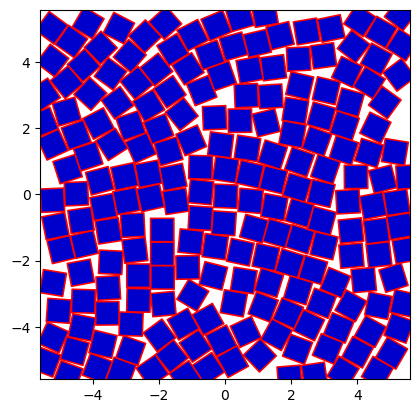

In [25]:
fig, ax = plt.subplots()
plot_snapshot(ax, sim.state.get_snapshot(), 4, 0.5,
              fc="mediumblue", ec="red")
plt.show()

In [26]:
hoomd.write.GSD.write(sim.state, "compressed.gsd", mode="wb")

# NPT Simulation

In [27]:
# reset the simulator
mc = hoomd.hpmc.integrate.ConvexPolygon(nselect=1)
mc.shape["square"] = dict(vertices=[
    (radius, 0.0),
    (0.0, radius),
    (-radius, 0.0),
    (0.0, -radius),
])

sim = hoomd.Simulation(device=cpu, seed=np.random.randint(np.iinfo(np.int16).max))
sim.create_state_from_gsd(filename='compressed.gsd')
sim.operations.integrator = mc

npt = hoomd.hpmc.update.BoxMC(trigger=hoomd.trigger.Periodic(N_particles), betaP=1e8)
npt.volume["weight"] = 1.0
sim.operations.updaters.append(npt)

## Tune Acceptance Ratio

In [28]:
tune = hoomd.hpmc.tune.MoveSize.scale_solver(
    moves=['a', 'd'],
    target=0.2,
    trigger=hoomd.trigger.And([
        hoomd.trigger.Periodic(100),
        hoomd.trigger.Before(sim.timestep + 10_000)
    ]))
sim.operations.tuners.append(tune)
sim.run(10_000)

In [29]:
sim.run(500)
translation_acceptance = mc.translate_moves[0] / sum(mc.translate_moves)
rotation_acceptance = mc.rotate_moves[0] / sum(mc.rotate_moves)
translation_acceptance, rotation_acceptance

(0.2061665076335878, 0.2031149388280747)

## Add Writer for Recording Multiple Steps

In [30]:
gsd_writer = hoomd.write.GSD(filename='trajectory.gsd', mode="wb",
                             trigger=hoomd.trigger.Periodic(1000))
sim.operations.writers.append(gsd_writer)

## Run the Simulation

In [31]:
sim.run(1_000_000)

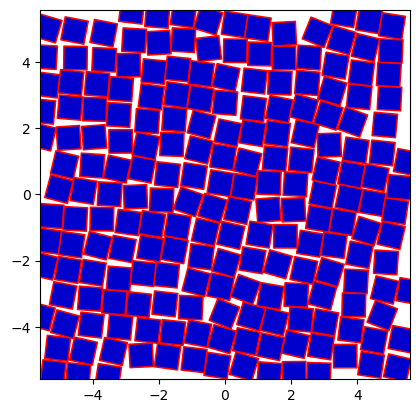

In [32]:
fig, ax = plt.subplots()
plot_snapshot(ax, sim.state.get_snapshot(), 4, 0.5,
              fc="mediumblue", ec="red")
plt.show()

## Animation

In [33]:
def animate_trajectory(traj, sidenum, radius, fps=15, **kwargs):
    fig, ax = plt.subplots()
    plot_snapshot(ax, traj[0], sidenum, radius, **kwargs)
    anim = mpl.animation.FuncAnimation(fig, animate_frame, frames=len(traj),
                                       blit=True, interval=1000/fps,
                                       fargs=(ax, ax.collections[0],
                                              traj, sidenum, radius))
    return anim

def animate_frame(frame, ax, patch_collection, traj, sidenum, radius):
    orientation = traj[frame].particles.orientation
    position = traj[frame].particles.position
    box = traj[frame].configuration.box

    angle = 2 * np.arccos(orientation[:, 0]) * np.sign(orientation[:, 3])
    patches = [mpl.patches.RegularPolygon(position[i, :-1], sidenum, radius, angle[i])
               for i in range(len(position))]
    patch_collection.set_paths(patches)

    box_x_extent = box[0] + box[3] * box[1]
    ax.set_xlim((-box_x_extent/2, box_x_extent/2))
    ax.set_ylim((-box[1]/2, box[1]/2))

    return patch_collection,

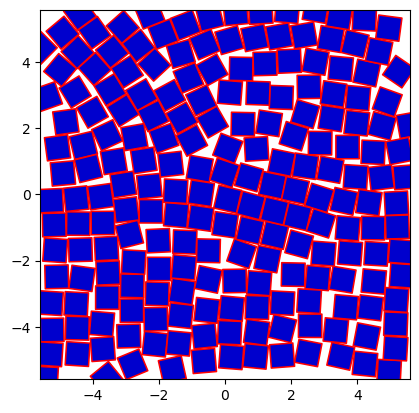

In [34]:
traj = gsd.hoomd.open("trajectory.gsd")
anim = animate_trajectory(traj, 4, 0.5, fc="mediumblue", ec="red")

In [35]:
ffpmeg_writer = mpl.animation.FFMpegWriter(fps=15, extra_args=["-preset", "veryslow"])
anim.save("../../anim/hoomd-demo-npt.mp4")